In [1]:
import json

def arrays_mean(arrays, weights):
    tot_weights = sum(weights)
    if len(arrays) == 0:
        return []

    ret = arrays[0]
    for i in range(0, len(ret)):
        ret[i] = ret[i]*weights[0]

    for i in range(1, len(arrays)):
        for j in range(0, len(arrays[0])):
                ret[j] += arrays[i][j]*weights[i]

    for i in range(0, len(ret)):
        ret[i] = ret[i]/(len(arrays)*tot_weights)

    return ret

def matrices_mean(matrices, weights):
    tot_weights = sum(weights)
    if len(matrices) == 0:
        return []

    ret = matrices[0]
    for i in range(0, len(ret)):
        for j in range(0, len(ret[0])):
            ret[i][j] = ret[i][j]*weights[0]

    for i in range(1, len(matrices)):
        for j in range(0, len(matrices[0])):
            for k in range(0, len(matrices[0][0])):
                ret[j][k] += matrices[i][j][k]*weights[i]

    for i in range(0, len(ret)):
        for j in range(0, len(ret[0])):
            ret[i][j] = ret[i][j]/(len(matrices)*tot_weights)

    return ret

def load_mean_config(file_path):
    f = open(file_path)
    config = json.load(f)
    f.close()
    ucs = config["classes"]
    margins = config["margins"]
    optimal_config = config["optimalConfig"]
    productList = [Product(int(key), ucs[0]["secondary"][key]) for key in ucs[0]["secondary"]] #same for each class

    convRates = []
    click_prob = []
    lambda_p = 0
    alphas = []
    units_mean = []
    users_mean = []
    users_variance = []

    for uc in ucs:
        #medie
        convRates.append(uc["conversionRates"])
        click_prob.append(uc["clickProbability"])
        lambda_p += uc["lambda"]
        alphas.append(uc["alphas"])
        units_mean.append(uc["unitsShape"])
        users_mean.append(uc["usersMean"])
        users_variance.append(uc["usersVariance"])

    lambda_p = lambda_p/len(ucs)
    alphas = arrays_mean(alphas, users_mean)
    units_mean = arrays_mean(units_mean, users_mean)
    click_prob = matrices_mean(click_prob, users_mean)
    convRates = matrices_mean(convRates, users_mean)

    num_prices = len(convRates[0])
    num_prods = len(alphas)

    pulledArm = [0, 3, 0, 2, 0] # [3, 2, 0, 3, 2]
    configuration = {"productList": productList, "click_prob": click_prob, "lambda_p": lambda_p, "alphas": alphas, "units_mean": units_mean,
                     "num_prices": num_prices, "num_prods": num_prods, "optimal_config": optimal_config, "pulledArm": pulledArm,
                     "margins": margins, "convRates": convRates, "usersMean": users_mean, "usersVariance": users_variance}
    return configuration

Configuration file  0 :
Optimal arm found:
	 [2, 2, 0, 3, 2] 
Optimal theoretical arm:
	 [2, 2, 0, 2, 2]


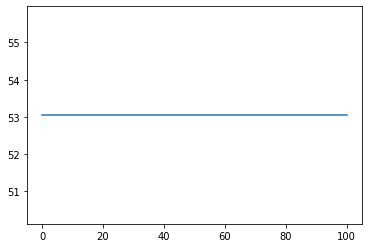

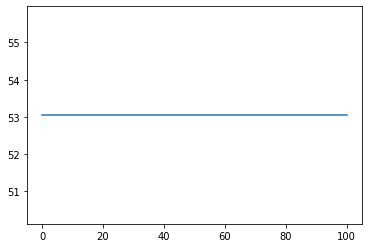

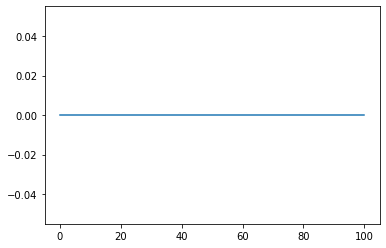

Configuration file  1 :
Optimal arm found:
	 [1, 1, 1, 1, 1] 
Optimal theoretical arm:
	 [1, 1, 1, 1, 1]


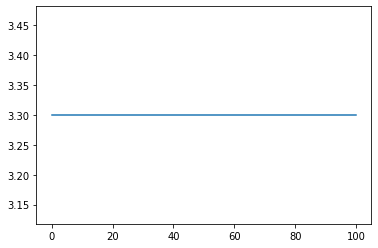

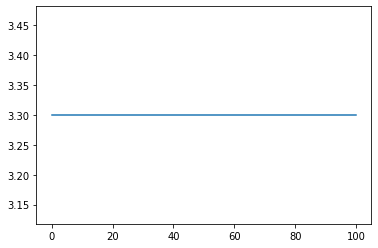

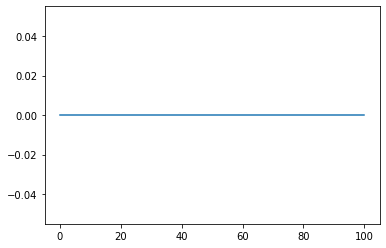

In [3]:
from Environment import Environment
from Learner.TS_GW import *
from Model.Product import *
import json
import matplotlib.pyplot as plt
from Model.Evaluator.GraphEvaluator import *

def total_margin_per_node(envReturn, marginsPerPrice, pulledArm):
    TotMargin = 0
    for e in envReturn["episodes"]:
        if e.bought:
            TotMargin += marginsPerPrice[e.product][pulledArm[e.product]] * e.units
    return TotMargin

files = ['./Configs/config1.json', './Configs/config3.json']
#files = ['./Configs/config1.json', './Configs/Config2.json']
env = []
tsLearners = []
config_margins = []
optimal_arms = []
conv_rates = []
prod_lists = []
click_probs = []
lambdas = []
alphas = []
units_means = []
n_experiments = 100
n_loops = 1

for i in range(0, len(files)):
    env.append(Environment(config_path=files[i]))
    config = load_mean_config(files[i])
    l = config["lambda_p"]

    tsLearners.append(TS_GW(margins=config["margins"], alphas=config["alphas"], secondary_prod=config["productList"],
                            conversion_rates=config["convRates"], l=l))
    config_margins.append(config["margins"])
    optimal_arms.append(config["optimal_config"])
    conv_rates.append(config["convRates"])
    prod_lists.append(config["productList"])
    click_probs.append(config["click_prob"])
    lambdas.append(config['lambda_p'])
    alphas.append(config["alphas"])
    units_means.append(config["units_mean"])

tot_ts_learner_margins = []
tot_optimal_margins = []

for i in range(0, len(env)):
    ts_learner_margins = np.array([])
    optimal_margins = np.array([])
    for j in range(0, n_experiments):
        ts_single_margin = 0
        opt_single_margin = 0
        armMargins = []
        armConvRates = []

    # compute the margin for the TS
        pulledArm = tsLearners[i].pull_arm()
        for k in range(0, len(pulledArm)):
            armMargins.append(config_margins[i][k][pulledArm[k]])
            armConvRates.append(conv_rates[i][k][pulledArm[k]])

        graphEval = GraphEvaluator(products_list=prod_lists[i], click_prob_matrix=click_probs[i], lambda_prob=lambdas[i],
                    alphas=alphas[i], conversion_rates=armConvRates, margins=armMargins, units_mean=units_means[i], verbose=False)

        env[i].setPriceLevels(pulledArm)
        for k in range(0, n_loops):
            ts_interactions = env[i].round()
            ts_single_margin += graphEval.computeMargin()
            #ts_single_margin += total_margin_per_node(ts_interactions, config_margins[i], pulledArm)
        ts_single_margin /= n_loops
        tsLearners[i].update(ts_interactions, pulledArm)

    # compute the margin for the optimal
        armConvRates = []
        armMargins = []
        pulledArm = optimal_arms[i]
        for k in range(0, len(pulledArm)):
            armMargins.append(config_margins[i][k][pulledArm[k]])
            armConvRates.append(conv_rates[i][k][pulledArm[k]])

        graphEval = GraphEvaluator(products_list=prod_lists[i], click_prob_matrix=click_probs[i], lambda_prob=lambdas[i],
                    alphas=alphas[i], conversion_rates=armConvRates, margins=armMargins, units_mean=units_means[i], verbose=False)

        env[i].setPriceLevels(pulledArm)
        for k in range(0, n_loops):
            opt_interactions = env[i].round()
            opt_single_margin += graphEval.computeMargin()
            #opt_single_margin += total_margin_per_node(opt_interactions, config_margins[i], pulledArm)
        opt_single_margin /= n_loops

        #add the margins
        ts_learner_margins = np.append(ts_learner_margins, ts_single_margin)
        optimal_margins = np.append(optimal_margins, opt_single_margin)

    tot_ts_learner_margins.append(ts_learner_margins)
    tot_optimal_margins.append(optimal_margins)
    print("Configuration file ", i, ":\nOptimal arm found:\n\t", tsLearners[i].pull_arm(), "\nOptimal theoretical arm:\n\t", optimal_arms[i])


    x = np.linspace(0, n_experiments, n_experiments)
    fig1, ax1 = plt.subplots()
    ax1.plot(x, tot_ts_learner_margins[i])
    fig2, ax2 = plt.subplots()
    ax2.plot(x, tot_optimal_margins[i])
    fig3, ax3 = plt.subplots()
    ax3.plot(x, tot_optimal_margins[i]-tot_ts_learner_margins[i])
    plt.show()